In [230]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle
from scipy.stats import spearmanr

import plotting_functions as pf
import analysis_functions as af
pf.set_fontsize(font_size=12)
%load_ext autoreload
%autoreload 2


dr_legend = {'pca': 'PCA', 'rbm': 'RBM', 'fa': 'FA', 'ica': 'ICA', 'glm': 'GLM'}
dr_colors = {'glm': '#008B8B', 'pca': '#808000', 'rbm': '#800080', 'fa': 'red', 'ica':'#157bf9'}

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


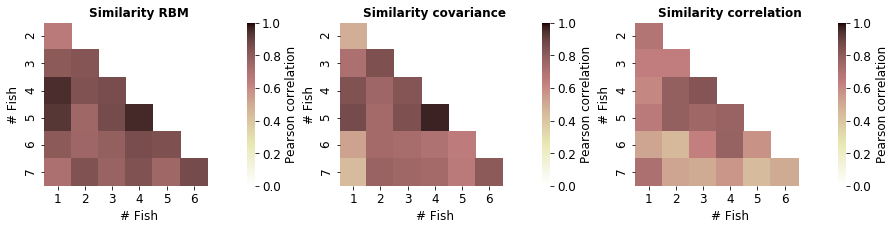

In [2]:
dict_reproducibility = af.load_reprod_matrix(swap=True, 
                                             path='/home/thijs/repos/zf-rbm/figures/figure_connectivity/panels_figure5/Reproducibility.txt')

fig = plt.figure(constrained_layout=False, figsize=[15, 3])
ax_sim = {}
for i_plot, plot_name in enumerate(['RBM', 'covariance', 'correlation']):
    ax_sim[i_plot] = plt.subplot(1, 3, 1 + i_plot)
    pf.plot_reproduc_mat(dict_mat=dict_reproducibility, key=plot_name,
                         ax=ax_sim[i_plot])
    ax_sim[i_plot].set_title(f'Similarity {plot_name}', fontdict={'weight': 'bold'})

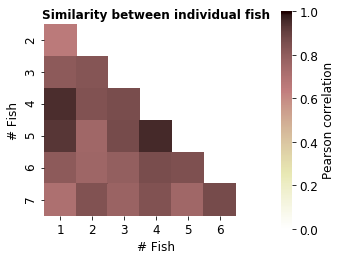

In [3]:
dict_reproducibility = af.load_reprod_matrix(swap=True, 
                                             path='/home/thijs/repos/zf-rbm/figures/figure_connectivity/panels_figure5/Reproducibility.txt')

fig = plt.figure(constrained_layout=False, figsize=[5, 4])
pf.plot_reproduc_mat(dict_mat=dict_reproducibility, key='RBM',
                     ax=fig.add_subplot())

## Jerome's fig;

In [28]:
averaging_weights.shape

(72, 72, 9)

In [29]:
## Takes up 8 GB RAM
version = '4'

env = pickle.load(open('/media/thijs/hooghoudt/connectivity_fig_data_jerome/connectivity_plot_files_v%s_no-neuron-connectivity.data'%version,'rb'))  # load light-weight version
# env = pickle.load(open('/media/thijs/hooghoudt/connectivity_fig_data_jerome/connectivity_plot_files_v%s.data'%version,'rb'))

runs = env['runs'] # List of experimental recordings used.
print(f'Loaded {len(runs)} runs')

# Baier matrices.
nRegions_baier = env['nRegions_baier'] # 72
assert nRegions_baier == 72
region_names_baier = env['region_names_baier'] # the region names, in the order displayed.

'''
There are various Baier matrices:
- his old version.
- his new version.
- the ones I rederived from his new data.
All viz are made with 'my_new_normalized_by_volume', but we can change at last stage if needed.
'''
selected_connectivity_type = 'my_new_normalized_by_volume'
connectivity_baier = env['connectivity_baier'] # The selected one. ( my_new_normalized .. )
all_baier_connectivities = env['all_baier_connectivities'] # All others.
connectivity_types = list(all_baier_connectivities.keys()) 

nNeurons_per_region = env['nNeurons_per_region'] # Number of neurons / region / recording.
mean_nNeurons_per_region = env['mean_nNeurons_per_region'] # Averaged number of neurons (across all recordings)

all_functional_connectivities = env['all_functional_connectivities']  # All functional connectivities inferred. For each run, each method, and each aggregation (L1 or L2 norm), one 72X72 matrix.
all_averaged_functional_connectivities = env['all_averaged_functional_connectivities'] # All functional connectivities inferred. For each run, each method, and each aggregation (L1 or L2 norm), one 72X72 matrix.
if 'all_neuron_connectivities' in env.keys():
    all_neuron_connectivities = env['all_neuron_connectivities']  # neuron to neuron connectivies, not present in light weight version 
methods = env['methods']
print(f'{methods} methods loaded')

averaging_weights = env['averaging_weights'] # The tensor of pair-weights used for producing the average functional connectivity (of size Nrecordings X Nregions X Nregions).
assert averaging_weights.ndim == 3

Loaded 9 runs
['RBM', 'covariance', 'correlation'] methods loaded


In [3]:
# region_names_baier  ## to write down abbreviation manually
# with open('/home/thijs/repos/zf-rbm/baier_atlas_labels/region_names_baier_abbreviations.txt', 'w') as f:
#     for name in region_names_baier:
#         f.write(name + '\n')

In [4]:
## Save light-weight version
# new_env = {k: v for k, v in env.items() if k != 'all_neuron_connectivities'}  # recreate without neuron neuron connection to save space
# with open('/media/thijs/hooghoudt/connectivity_fig_data_jerome/connectivity_plot_files_v%s_no-neuron-connectivity.data'%version, 'wb') as f:
#     pickle.dump(new_env, f)

In [19]:
kunst_region_order = {}
kunst_region_order['inds'], kunst_region_order['names'] = af.create_mapping_kunstea_order(current_regions=region_names_baier)
# kunst_region_order

In [242]:
aggregations = [1, 2]
selected_aggregation = 1 # Use L1 norm for the averaged.

output_folder = '/home/thijs/repos/zf-rbm/figures/figure_connectivity/panels_figure5_v4/'

'''
Determine "subset", the subset of regions onto which we perform analysis.
Here: At least 5 neurons on average for both the left and right region.
'''
Nmin = 5
subset = np.zeros(nRegions_baier, dtype='bool')
for i in range(nRegions_baier // 2):
    if (mean_nNeurons_per_region[2 * i] >= Nmin) & (mean_nNeurons_per_region[2 * i + 1] >= Nmin):  # left & right
        subset[2 * i] = 1
        subset[2 * i + 1] = 1
subset = np.nonzero(subset)[0]

'''
Determine the recording-level subset of regions. Useful for pairwise comparison and recording visualization.
'''
nNeurons_per_region_symmetrical = np.concatenate([np.concatenate([nNeurons_per_region[2*i+1:2*i+2,:],
                                                                  nNeurons_per_region[2*i:2*i+1]], axis=0) for i in range(nRegions_baier//2)], axis=0)  # size n_regions x n_fish
relevant_regions = np.zeros(nNeurons_per_region.shape, dtype=bool)  # shape n_regions x n_fish
relevant_regions[subset,:] = (nNeurons_per_region[subset, :] >= Nmin) & (nNeurons_per_region_symmetrical[subset, :] >= Nmin)
relevant_regions2 = relevant_regions[:, np.newaxis] * relevant_regions[np.newaxis, :, :]    # shape n_regions x n_regions x n_fish
nRuns = len(runs)    
all_masks = relevant_regions2.reshape([nRegions_baier ** 2, nRuns]).T 

In [251]:
all_masks.shape

(9, 5184)

In [127]:
## show single dataset heatmaps
all_spearman = {}
all_pearson = {}
all_spearman_averaged = {}
all_pearson_averaged = {}
connectivity_key_format = 'run:{run}_method:{method}_agg:{aggregation}'
correlation_key_format = 'run:{run}_method:{method}_agg:{aggregation}_conn:{connectivity_type}'
averaged_connectivity_key_format = 'method:{method}_agg:{aggregation}'
correlation_averaged_connectivity_key_format = 'method:{method}_agg:{aggregation}_conn:{connectivity_type}'

## Compute spearman and pearson correlation between each functional connectivity set & Baier.
for k, run in enumerate(runs):
    for method in methods:
        for aggregation in aggregations:
            key_dict = connectivity_key_format.format(
                run=run, method=method, aggregation=aggregation)
            prediction = all_functional_connectivities[key_dict].copy()  # use individual connectivity
            for connectivity_type in connectivity_types:
                target = all_baier_connectivities[connectivity_type].copy()
                if connectivity_type in ['his_old', 'his_new']:
                    target[np.arange(len(target)), np.arange(
                        len(target))] += 1.0 * target.max()  # They did not define a diagonal connexion (intra-region connectivity). Set to the maximum value across all entry.

                flat_target = target.flatten()[all_masks[k]] # Baier connectivity of non-zero regions
                flat_prediction = prediction.flatten()[all_masks[k]] # Functional connectivity of non-zero regions
                # flat_target = target[subset, :][:, subset].flatten()
                # flat_prediction = prediction[subset,
                #                              :][:, subset].flatten()
                spearman = spearmanr(
                    flat_target, flat_prediction).correlation  # compute correlations
                pearson = np.corrcoef(
                    flat_target, flat_prediction)[0, 1]

                key = correlation_key_format.format(
                    run=run, method=method, aggregation=aggregation, connectivity_type=connectivity_type)
                all_spearman[key] = spearman
                all_pearson[key] = pearson

## Compute average spearman and pearson correlation.
## (essentially just the run loop is missing here)
for connectivity_type in connectivity_types:
    for method in methods:
        for aggregation in aggregations:
            prediction = all_averaged_functional_connectivities[averaged_connectivity_key_format.format(
                method=method, aggregation=aggregation)]  # use averaged connectivity (across fish)
            target = all_baier_connectivities[connectivity_type].copy()
            if connectivity_type in ['his_old', 'his_new']:
                target[np.arange(len(target)), np.arange(
                    len(target))] += 1.0 * target.max()

            flat_target = target[subset, :][:, subset].flatten()
            flat_prediction = prediction[subset,
                                         :][:, subset].flatten()

            spearman = spearmanr(
                flat_target, flat_prediction).correlation
            pearson = np.corrcoef(flat_target, flat_prediction)[0, 1]

            key = correlation_averaged_connectivity_key_format.format(
                method=method, aggregation=aggregation,connectivity_type=connectivity_type)
            all_spearman_averaged[key] = spearman
            all_pearson_averaged[key] = pearson

# Make region filters.
all_correlations = {}   
for method in methods:
    correlation = np.zeros([nRuns,nRuns])
    for k1,run1 in enumerate(runs):
        for k2,run2 in enumerate(runs):
            key1 = 'run:%s_method:%s_agg:%s'%(run1,method,selected_aggregation)
            key2 = 'run:%s_method:%s_agg:%s'%(run2,method,selected_aggregation)
            connections1 = all_functional_connectivities[key1].flatten()
            connections2 = all_functional_connectivities[key2].flatten()
            mask = all_masks[k1] & all_masks[k2]
#             correlation[k1,k2] = np.corrcoef(connections1[mask],connections2[mask])[0,1]   
            correlation[k1, k2] = np.corrcoef(np.log10(connections1[mask]),
                                              np.log10(connections2[mask]))[0,1]
     
            # correlation[k1,k2] = (connections1[mask]*connections2[mask]).mean()/np.sqrt( (connections1[mask]**2).mean() * (connections2[mask]**2).mean() )
    all_correlations[method] = {'pearson': correlation, 'run_names': runs}

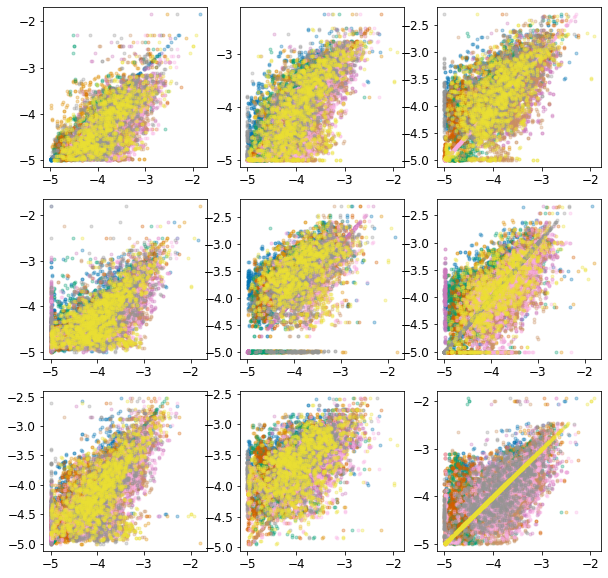

In [163]:
# fig, ax = plt.subplots(nRuns, nRuns, figsize=[20, 20])
fig, ax = plt.subplots(3, 3, figsize=[10, 10])
method = 'RBM'
aggregation = 1
all_connections_tensor = np.zeros((72, 72, 9))
all_connections_array = np.array([])
correlation = np.zeros([nRuns,nRuns])
for k1, run1 in enumerate(runs):
    i_row = k1 % 3
    i_col = int(np.floor(k1 / 3))
    
    for k2, run2 in enumerate(runs):
        key1 = 'run:%s_method:%s_agg:%s'%(run1, method, selected_aggregation)
        key2 = 'run:%s_method:%s_agg:%s'%(run2, method, selected_aggregation)
        connections1 = all_functional_connectivities[key1].flatten()
        connections2 = all_functional_connectivities[key2].flatten()
        mask = all_masks[k1] & all_masks[k2]  # mutual masks
        ax[i_row][i_col].plot(np.log10(connections2[mask] + 1e-5), 
                              np.log10(connections1[mask] + 1e-5), '.', alpha=0.3)
#         ax[i_row][i_col].set_aspect('equal', adjustable='box')
#         ax[i_row][i_col].set_xlim([-5, -1])
#         ax[i_row][i_col].set_ylim([-5, -1])
#         ax[i_row][i_col].set_xlim([0, 0.005])
#         ax[i_row][i_col].set_ylim([0, 0.005])
    all_connections_array = np.concatenate((all_connections_array, connections1))
    all_connections_tensor[:, :, k1] = all_functional_connectivities[key1]

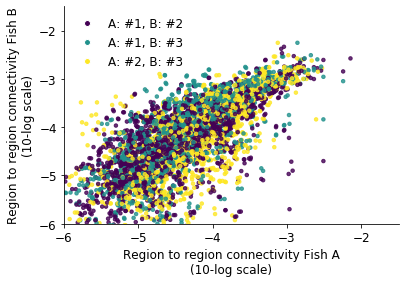

In [235]:
pf.plot_multi_fish_connectivity_scatter(all_connections_tensor=all_connections_tensor, 
                                        fish_combinations=[(1, 2), (1, 3), (2, 3)],
                                        axis_lim=[-6, -1.5])

In [178]:
np.sum(np.isnan(all_connections_tensor))

0

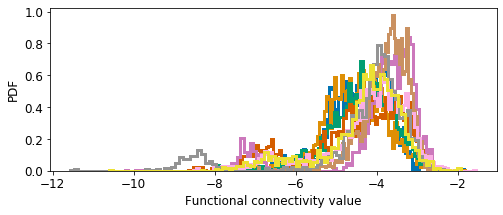

In [177]:
fig, ax = plt.subplots(1, 1, figsize=(8, 3))
for i_fish in range(9):
    tmp_dens = all_connections_tensor[: ,:, i_fish]
    ax.hist(np.log10(tmp_dens[tmp_dens > 0]), bins=100, density=True, histtype='step', linewidth=3);
ax.set_xlabel('Functional connectivity value');
ax.set_ylabel('PDF');

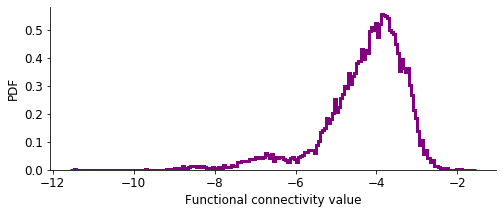

In [233]:
fig, ax = plt.subplots(1, 1, figsize=(8, 3))
ax.hist(np.log10(all_connections_array[all_connections_array > 0]), 
        bins=200, density=True, histtype='step', linewidth=3, color=dr_colors['rbm']);
ax.set_xlabel('Functional connectivity value');
ax.set_ylabel('PDF');
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

19915 46656
RBM 3219 5184
covariance 3219 5184


/home/thijs/.conda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in greater
  if __name__ == '__main__':
/home/thijs/.conda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in greater
  # Remove the CWD from sys.path while we load stuff.


correlation 3219 5184


(-10, -2)

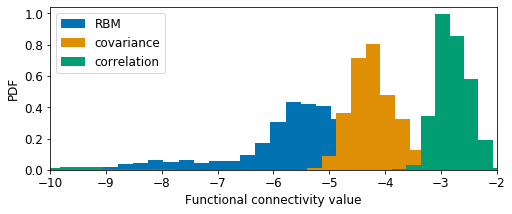

In [176]:
fig, ax = plt.subplots(1, 1, figsize=(8, 3))
# ax.hist(np.sqrt(all_connections_array[all_connections_array > 0]), bins=200, density=True);
ax.set_xlabel('Functional connectivity value');
ax.set_ylabel('PDF');
print(len(all_connections_array[all_connections_array > 0]), len(all_connections_array))

for method in methods:
    tmp_dens = all_averaged_functional_connectivities[f'method:{method}_agg:1'].ravel()
    ax.hist(np.log10(tmp_dens[tmp_dens > 0]), bins=200, density=True, label=method);
    print(method, len(tmp_dens[tmp_dens > 0]), len(tmp_dens))
ax.legend()
ax.set_xlim([-10, -2])

/home/thijs/.conda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


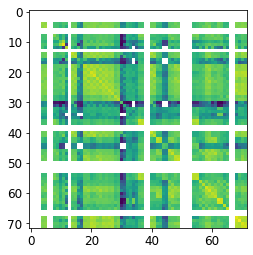

In [168]:
plt.plot(np.log(np.nanmean(all_connections_tensor, 2)))

Text(0.5, 1.0, 'correlation')

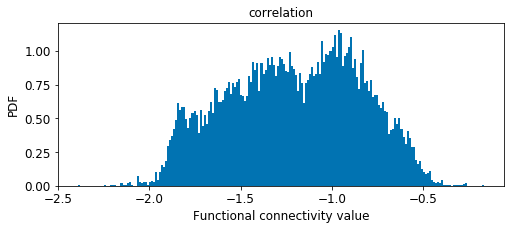

In [134]:
fig, ax = plt.subplots(1, 1, figsize=(8, 3))
ax.hist(np.log10(all_connections_array[all_connections_array > 0]), bins=200, density=True);
ax.set_xlabel('Functional connectivity value');
ax.set_ylabel('PDF');
ax.set_title('correlation')

Text(0.5, 1.0, 'covariance')

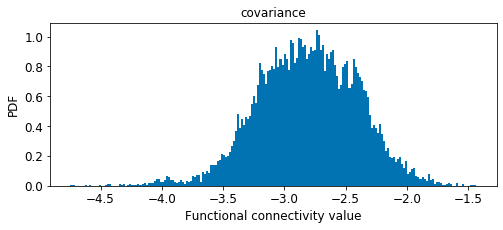

In [136]:
fig, ax = plt.subplots(1, 1, figsize=(8, 3))
ax.hist(np.log10(all_connections_array[all_connections_array > 0]), bins=200, density=True);
ax.set_xlabel('Functional connectivity value');
ax.set_ylabel('PDF');
ax.set_title('covariance')

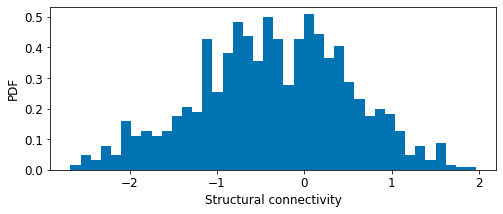

In [123]:
fig, ax = plt.subplots(1, 1, figsize=(8, 3))
baier_conn = all_baier_connectivities['my_new_normalized_by_volume']
ax.hist(np.log10(baier_conn[baier_conn > 0]), bins=40, density=True);
ax.set_xlabel('Structural connectivity')
ax.set_ylabel('PDF');

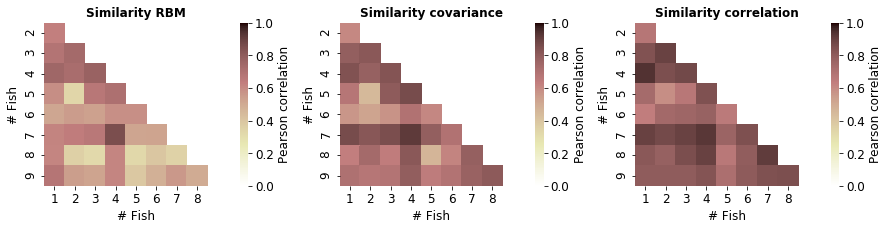

In [129]:
fig = plt.figure(constrained_layout=False, figsize=[15, 3])
ax_sim = {}
for i_plot, plot_name in enumerate(['RBM', 'covariance', 'correlation']):
    ax_sim[i_plot] = plt.subplot(1, 3, 1 + i_plot)
    pf.plot_reproduc_mat(dict_mat=all_correlations, key=plot_name,
                         ax=ax_sim[i_plot])
    ax_sim[i_plot].set_title(f'Similarity {plot_name}', fontdict={'weight': 'bold'})

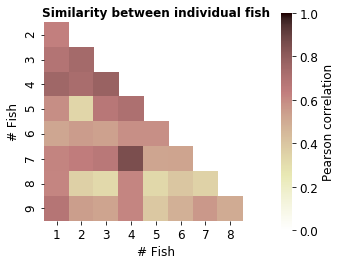

In [128]:
fig = plt.figure(constrained_layout=False, figsize=[5, 4])
pf.plot_reproduc_mat(dict_mat=all_correlations, key='RBM',
                     ax=fig.add_subplot())
# plt.savefig('/home/thijs/repos/zf-rbm/figures/figure_connectivity/panels_figure5_v3/similarity_individ_fish.png', dpi=300)

In [10]:
## Determining mini & maxi for plotting - not necesssary 

# method = 'RBM'
# assert selected_aggregation == 1
# tmp_all_connectivity = np.zeros((len(runs), nRegions_baier, nRegions_baier))
# for k, run in enumerate(runs):
#     key_matrix = connectivity_key_format.format(
#         run=run, method=method, aggregation=selected_aggregation)
#     key_correlation = correlation_key_format.format(
#         run=run, method=method, aggregation=selected_aggregation, connectivity_type=selected_connectivity_type)
#     prediction = all_functional_connectivities[key_matrix]
#     prediction_ = prediction.copy()
#     prediction_[~all_masks[k].reshape([nRegions_baier,nRegions_baier])] = np.nan
#     tmp_all_connectivity[k, :, :] = prediction_

# tmp = tmp_all_connectivity.flatten()
# tmp = tmp[np.logical_not(np.isnan(tmp))]
# tmp = np.log10(tmp)
# mini = np.percentile(tmp, 10)
# maxi = np.percentile(tmp, 90)
# print(mini, maxi)

-5.1563117323756344 -3.225527597704281


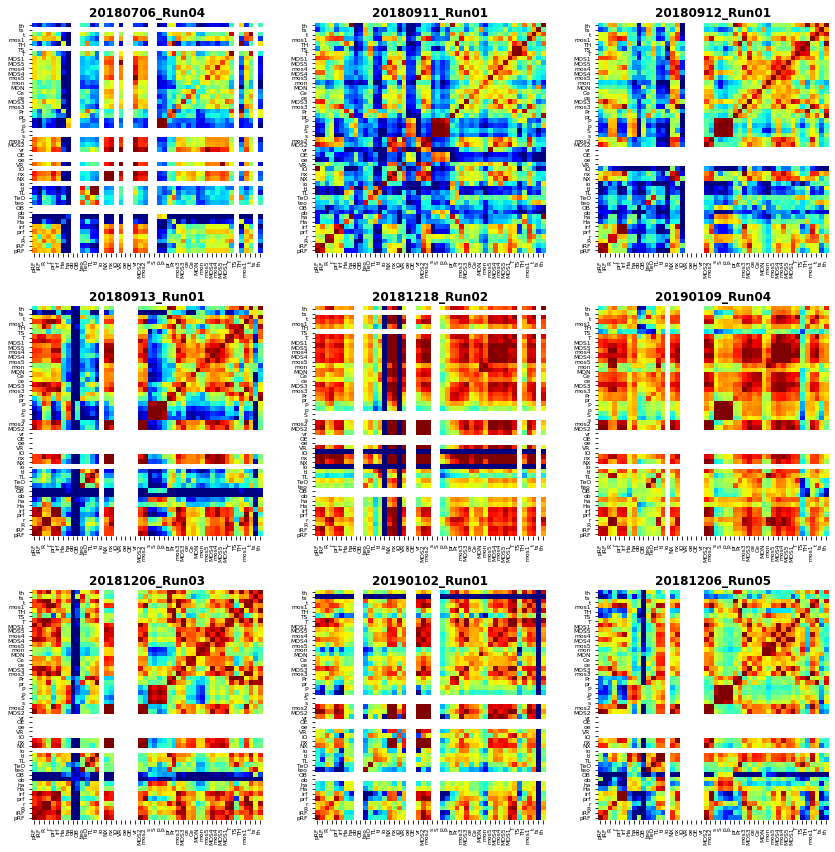

In [307]:
nRuns = len(runs)    
assert runs == all_correlations['RBM']['run_names']
# for method in methodsshow_connectivity
save_fig = False
method = 'RBM'
nrows = 3
ncols = int(np.ceil(nRuns/nrows))
fig, ax = plt.subplots(nrows, ncols, figsize=[12, 12])
# fig.set_figheight(nrows * 6)
# fig.set_figwidth(ncols * 6)
for k, run in enumerate(runs):
    i = k // ncols
    j = k % ncols

    index_run = np.where(np.array(all_correlations['RBM']['run_names']) == run)[0]
    assert len(index_run) == 1
    key_matrix = connectivity_key_format.format(
        run=run, method=method, aggregation=selected_aggregation)
    key_correlation = correlation_key_format.format(
        run=run, method=method, aggregation=selected_aggregation, connectivity_type=selected_connectivity_type)
    prediction = all_functional_connectivities[key_matrix]
    prediction_ = prediction.copy()
    prediction_[~all_masks[index_run].reshape([nRegions_baier,nRegions_baier])] = np.nan  # add nans for empty regions

    spearman = all_spearman[key_correlation]  # precomputed correlatoin with Baier 
    pearson = all_pearson[key_correlation]
    ax[i, j] = pf.plot_connectivity_matrix(prediction_, region_names_baier, mini=-5.5, maxi=-3,
                                size=5, ax=ax[i,j], subset=subset, plot_log=True, scale_limits=True,
                                region_order_dict=kunst_region_order, plot_labels=True)
#     ax[i, j].set_title('Fish #%s , Spearman = %.3f, Pearson = %.3f' % (
#         index_run[0] + 1, spearman, pearson), fontsize=12, fontdict={'weight': 'bold'})
    ax[i, j].set_title(f'{run}', fontsize=12, fontdict={'weight': 'bold'})
    
# pf.plot_reproduc_mat(dict_mat=all_correlations, key='RBM',
#                  ax=ax[3, 2])
plt.tight_layout()
if save_fig:
    fig.savefig('/home/thijs/repos/zf-rbm/figures/figure_connectivity/panels_figure5_v3/individual_rbms.png', dpi=300)


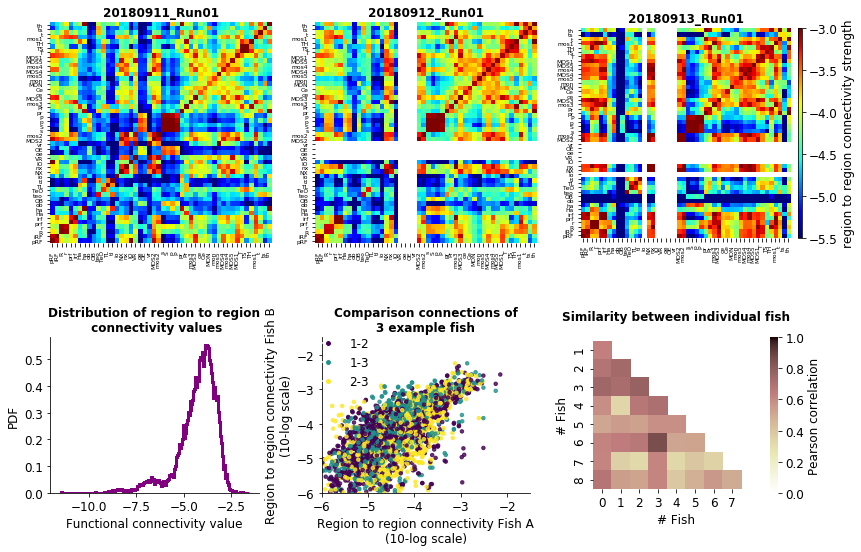

In [299]:
plot_runs = ['20180911_Run01', '20180912_Run01', '20180913_Run01']
save_fig = True
selected_connectivity_type = 'my_new_normalized_by_volume'


fig = plt.figure(constrained_layout=False, figsize=[12, 8])
gs_matrix = fig.add_gridspec(ncols=3, nrows=1, bottom=0.5, top=0.95, 
                             hspace=0.1, wspace=0.2, left=0.05, right=0.92)
gs_stats = fig.add_gridspec(ncols=3, nrows=1, bottom=0.1, top=0.37, 
                             hspace=0.1, wspace=0.3, left=0.05, right=0.92)

ax_mat = {}

for k, run in enumerate(plot_runs):
    ax_mat[k] = fig.add_subplot(gs_matrix[k])
    index_run = np.where(np.array(all_correlations['RBM']['run_names']) == run)[0]
    assert len(index_run) == 1
    key_matrix = connectivity_key_format.format(
        run=run, method='RBM', aggregation=1)
    key_correlation = correlation_key_format.format(
        run=run, method='RBM', aggregation=1, connectivity_type=selected_connectivity_type)
    prediction = all_functional_connectivities[key_matrix]
    prediction_ = prediction.copy()
    prediction_[~all_masks[index_run].reshape([nRegions_baier,nRegions_baier])] = np.nan  # add nans for empty regions

    spearman = all_spearman[key_correlation]  # precomputed correlatoin with Baier 
    pearson = all_pearson[key_correlation]
    if k == 2:
        plot_cbar = True
    else:
        plot_cbar = False
    ax_mat[k] = pf.plot_connectivity_matrix(prediction_, region_names_baier, mini=-5.5, maxi=-3,
                                            size=5, ax=ax_mat[k], subset=subset, plot_log=True, scale_limits=True,
                                            region_order_dict=kunst_region_order, plot_labels=True,
                                            cbar=plot_cbar)
#     ax_mat[k].set_title('Fish #%s , Spearman = %.3f, Pearson = %.3f' % (
#         index_run[0] + 1, spearman, pearson), fontsize=12, fontdict={'weight': 'bold'})
    ax_mat[k].set_title(run, fontsize=12, fontdict={'weight': 'bold'})
    


ax_dens = fig.add_subplot(gs_stats[0])
ax_dens.hist(np.log10(all_connections_array[all_connections_array > 0]), 
        bins=200, density=True, histtype='step', linewidth=3, color=dr_colors['rbm']);
ax_dens.set_xlabel('Functional connectivity value');
ax_dens.set_ylabel('PDF');
ax_dens.spines['top'].set_visible(False)
ax_dens.spines['right'].set_visible(False)
ax_dens.set_title('Distribution of region to region\n connectivity values', 
                  fontdict={'weight': 'bold'})
ax_scatter = fig.add_subplot(gs_stats[1])
pf.plot_multi_fish_connectivity_scatter(all_connections_tensor=all_connections_tensor, 
                                        fish_combinations=[(1, 2), (1, 3), (2, 3)],
                                        axis_lim=[-6, -1.5], ax=ax_scatter)
ax_scatter.set_title('Comparison connections of\n3 example fish', fontdict={'weight': 'bold'})

ax_corr = fig.add_subplot(gs_stats[2])
pf.plot_reproduc_mat(dict_mat=all_correlations, key='RBM',
                 ax=ax_corr)
ax_corr.set_title('Similarity between individual fish\n', 
                  fontdict={'weight': 'bold'});
if save_fig:
    fig.savefig('/home/thijs/repos/zf-rbm/figures/fig_connectivity_individuals.pdf', dpi=300)


In [236]:
runs

['20180706_Run04',
 '20180911_Run01',
 '20180912_Run01',
 '20180913_Run01',
 '20181218_Run02',
 '20190109_Run04',
 '20181206_Run03',
 '20190102_Run01',
 '20181206_Run05']

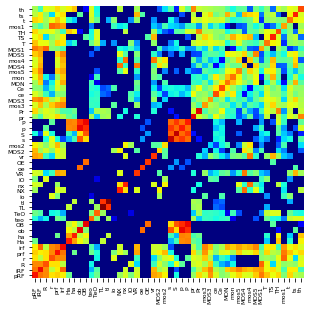

In [94]:
tmp = pf.plot_connectivity_matrix(matrix=all_baier_connectivities['my_new_normalized_by_volume'] + 1e-6, 
                                  cbar=False, plot_log=True, scale_limits=True,
                                  region_names=region_names_baier, size=5, mini=-3, maxi=2,
                                  region_order_dict=kunst_region_order, 
                                  reverse_x=True, subset=subset)
# plt.colorbar(tmp)

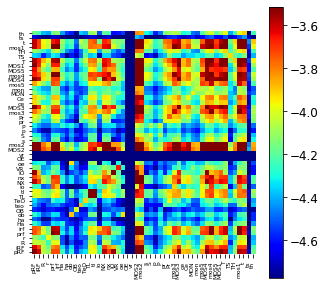

In [15]:
tmp = pf.plot_connectivity_matrix(matrix=all_averaged_functional_connectivities['method:covariance_agg:1'], 
                                  cbar=True, plot_log=True,
                            region_names=region_names_baier, size=5, scale_limits=True,
                                  region_order_dict=kunst_region_order, reverse_x=True, subset=subset)
# plt.colorbar(tmp)

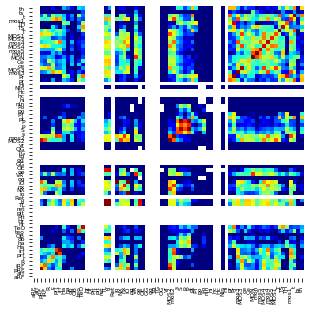

In [96]:
tmp = pf.plot_connectivity_matrix(matrix=all_averaged_functional_connectivities['method:RBM_agg:1'], 
                                  cbar=False, plot_log=True, mini=-6, maxi=-4,
                                  region_names=region_names_baier, size=5, scale_limits=True,
                                  region_order_dict=kunst_region_order, 
                                  reverse_x=True)#, subset=subset)
# plt.colorbar(tmp)

In [16]:
all_pearson_averaged

{'method:RBM_agg:1_conn:his_old': 0.4643146184153721,
 'method:RBM_agg:2_conn:his_old': 0.5026691446658322,
 'method:covariance_agg:1_conn:his_old': 0.24833690031319594,
 'method:covariance_agg:2_conn:his_old': 0.24986585475598042,
 'method:correlation_agg:1_conn:his_old': 0.35137367479234727,
 'method:correlation_agg:2_conn:his_old': 0.35014163116002367,
 'method:RBM_agg:1_conn:his_new': 0.47494840791949294,
 'method:RBM_agg:2_conn:his_new': 0.49310672615654016,
 'method:covariance_agg:1_conn:his_new': 0.18262804259359713,
 'method:covariance_agg:2_conn:his_new': 0.17687340242555458,
 'method:correlation_agg:1_conn:his_new': 0.24923933556016753,
 'method:correlation_agg:2_conn:his_new': 0.243355730566362,
 'method:RBM_agg:1_conn:my_new_unnormalized': 0.2959891030305321,
 'method:RBM_agg:2_conn:my_new_unnormalized': 0.34008539874578225,
 'method:covariance_agg:1_conn:my_new_unnormalized': 0.08275476466533756,
 'method:covariance_agg:2_conn:my_new_unnormalized': 0.09416782876912547,
 'm

(48, 48)
2 (2012,)
1 (1165,)
(1165,)
RBM 0.5954282700553244 0.28419607970633803
(48, 48)
2 (2115,)
1 (1175,)
(1175,)
covariance 0.06077773460763975 0.12482175664115419
(48, 48)
2 (2115,)
1 (1175,)
(1175,)
correlation 0.1309642038427101 0.22789904062813954


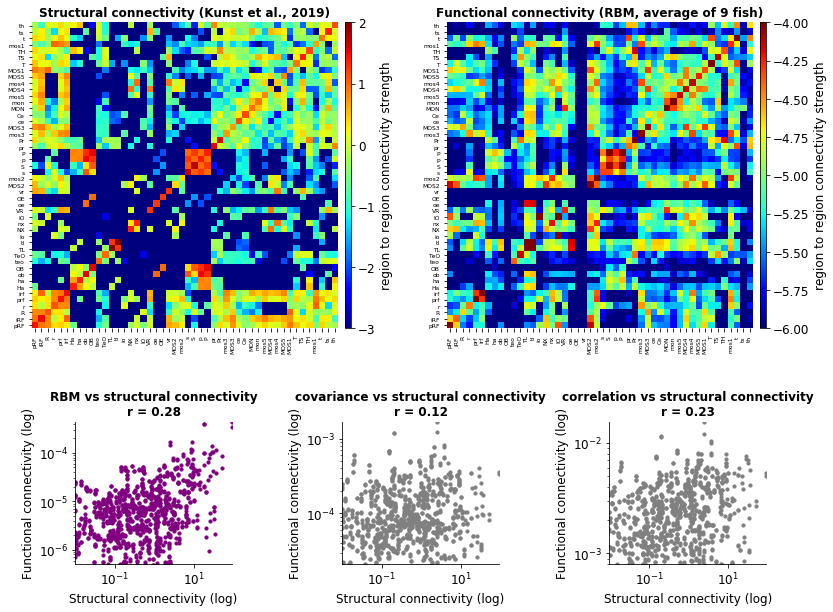

In [308]:
save_fig = False
fig = plt.figure(figsize=[12, 9])
gs_matrices = fig.add_gridspec(ncols=2, nrows=1, left=0.05, right=0.9, top=0.95,
                               bottom=0.45, wspace=0.3, hspace=0)
gs_bottom = fig.add_gridspec(ncols=3, nrows=1, left=0.1, right=0.9, top=0.32, bottom=0.1,
                             wspace=0.7)
ax_baier = fig.add_subplot(gs_matrices[0])
ax_rbm = fig.add_subplot(gs_matrices[1])

pf.plot_connectivity_matrix(matrix=all_baier_connectivities['my_new_normalized_by_volume'] + 1e-6, 
                          cbar=True, plot_log=True, scale_limits=True,
                          region_names=region_names_baier, mini=-3, maxi=2,
                          region_order_dict=kunst_region_order, 
                          reverse_x=True, subset=subset, ax=ax_baier)
ax_baier.set_title('Structural connectivity (Kunst et al., 2019)', 
                   fontdict={'weight': 'bold'})

pf.plot_connectivity_matrix(matrix=all_averaged_functional_connectivities['method:RBM_agg:1'], 
                          cbar=True, plot_log=True, mini=-6, maxi=-4,
                            region_names=region_names_baier, size=5, scale_limits=False,
                          region_order_dict=kunst_region_order, 
                          reverse_x=True, subset=subset, ax=ax_rbm)

ax_rbm.set_title('Functional connectivity (RBM, average of 9 fish)', 
                 fontdict={'weight': 'bold'})

ax_comparison = {}
for i_meth, method in enumerate(['RBM', 'covariance', 'correlation']):
    ax_comparison[method] = fig.add_subplot(gs_bottom[i_meth])
    pearson_corr, spearman_corr = pf.plot_funct_vs_struct(struct_mat=all_baier_connectivities['my_new_normalized_by_volume'],
                            funct_mat=all_averaged_functional_connectivities[f'method:{method}_agg:1'],
                            ax=ax_comparison[method], subset=subset, key=method)
    ax_comparison[method].set_title(f'{method} vs structural connectivity\nr = {np.round(spearman_corr, 2)}',
                                    fontdict={'weight': 'bold'})
    
#     ax_comparison[method].set_

if save_fig:
    plt.savefig('/home/thijs/repos/zf-rbm/figures/fig_connectivity_structural_comparison.pdf', dpi=300)

In [20]:
'RBM'.lower()

'rbm'

/home/thijs/repos/zf-rbm/figure_notebooks/plotting_functions.py:538: RuntimeWarning: invalid value encountered in greater
  mat = mat[np.where(mat > min_th)]


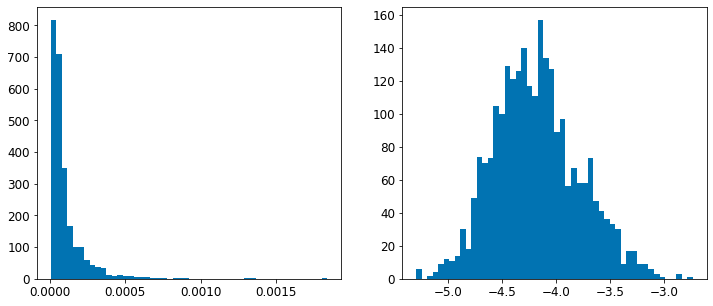

In [21]:
pf.plot_distr(all_averaged_functional_connectivities['method:covariance_agg:1'])

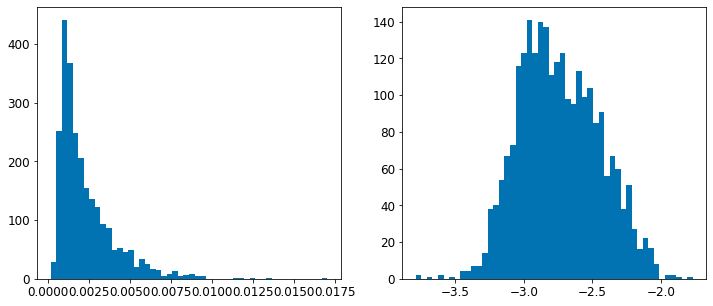

In [22]:
pf.plot_distr(all_averaged_functional_connectivities['method:correlation_agg:1'], 
              min_th=1e-4)

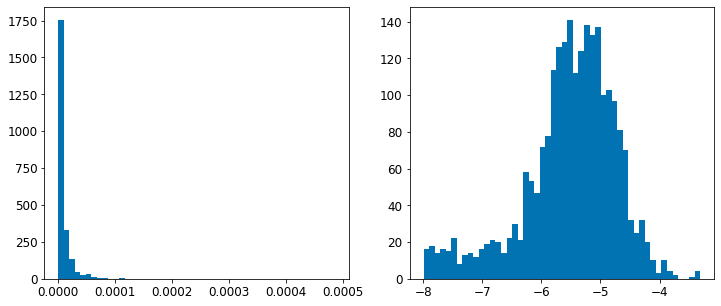

In [23]:
pf.plot_distr(all_averaged_functional_connectivities['method:RBM_agg:1'])

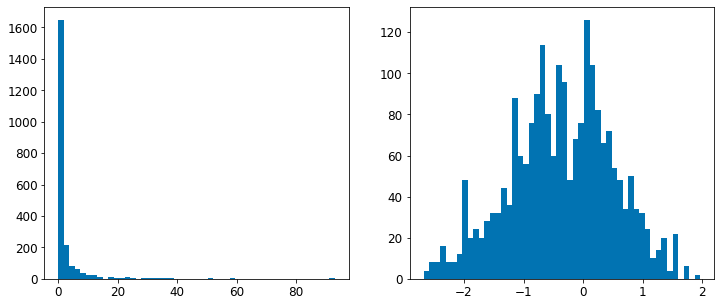

In [24]:
pf.plot_distr(all_baier_connectivities['my_new_normalized_by_volume'])